In [1]:
pip install sklearn-crfsuite

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.1 MB 10.8 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings; warnings.simplefilter('ignore')
import numpy as np
from sklearn import preprocessing
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import timeit
import random
import pickle
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Function to read OCR dataset
def read_OCR(filename, n_features):
    dataset = {
        'ids': [],
        'labels': [],
        'labelDic': {},
        'next_ids': [],
        'word_ids': [],
        'positions': [],
        'folds': [],
        'features': [],
    }
    
    with open(filename) as F:
        for str_line in F:
            line0 = list(map(iors, filter(None, re.split('\t', str_line.strip()))))
            dataset['ids'].append(int(line0.pop(0)))
            dataset['labels'].append(l2i(line0.pop(0)))
            if dataset['labels'][-1] in dataset['labelDic']:
                dataset['labelDic'][dataset['labels'][-1]] += 1
            else:
                dataset['labelDic'][dataset['labels'][-1]] = 1
                
            dataset['next_ids'].append(int(line0.pop(0)))
            dataset['word_ids'].append(int(line0.pop(0)))
            dataset['positions'].append(int(line0.pop(0)))
            dataset['folds'].append(int(line0.pop(0)))
            dataset['features'].append(line0)
    
    return dataset

def l2i(a):
    return int(ord(a) - ord('a'))

def i2l(i):
    if i >= 0:
        return chr(i + ord('a'))
    else:
        return '_'

def iors(s):
    try:
        return int(s)
    except ValueError:
        return s

def structurize1(dataset, N, L):
    d_features = len(dataset['features'][0])
    y = dataset['labels']
    X = dataset['features']
    next_id = dataset['next_ids']

    labels = np.zeros((N, L))
    features = np.zeros((N, L * d_features))

    def extract(iN, loc):
        labels[iN] = y[loc:loc + L]
        features[iN] = np.array(X[loc:loc + L]).ravel().tolist()
        iN += 1
        return iN

    iN = 0
    iN = extract(iN, 0)

    for key, value in enumerate(y):
        if next_id[key] == -1:
            iN = extract(iN, key + 1)
            if iN == N:
                break

    c = list(zip(labels, features))
    random.shuffle(c)
    labels, features = zip(*c)
    return np.array(labels), np.array(features)

def prepare_data_for_crf(labels, features):
    crf_data = []
    for feature_set in features:
        feature_dicts = []
        for i in range(len(feature_set) // 128):
            feature_dict = {}
            for j in range(128):
                feature_dict[f'f{j}'] = feature_set[i * 128 + j]
            feature_dicts.append(feature_dict)
        crf_data.append(feature_dicts)
    return crf_data

# Read dataset
dataset1 = read_OCR('OCRdataset/letter.data', 128)

L_values = [2, 3, 4, 5]
splits = [(1000, 4000), (2500, 2500), (4000, 1000)]
N = 5000
d = 128

for L in L_values:
    labels1, features1 = structurize1(dataset1, N, L)
    
    le1 = preprocessing.LabelEncoder()
    nplabels1 = le1.fit_transform(labels1.ravel()).reshape(labels1.shape)

    crf_features = prepare_data_for_crf(labels1, features1)
    crf_labels = [list(map(str, seq)) for seq in nplabels1]
    
    for train_size, test_size in splits:
        X_train = crf_features[:train_size]
        y_train = crf_labels[:train_size]
        X_test = crf_features[train_size:train_size + test_size]
        y_test = crf_labels[train_size:train_size + test_size]

        crf = sklearn_crfsuite.CRF(
            algorithm='lbfgs',
            c1=0.1,
            c2=0.1,
            max_iterations=100,
            all_possible_transitions=False
        )
        
        start_train = timeit.default_timer()
        crf.fit(X_train, y_train)
        end_train = timeit.default_timer()
        print(f"Training time elapsed for L={L}, train_size={train_size}, test_size={test_size}:",
              end_train - start_train, "s")

        start_test = timeit.default_timer()
        y_pred = crf.predict(X_test)
        accuracy = metrics.flat_accuracy_score(y_test, y_pred)
        end_test = timeit.default_timer()
        print(f"Accuracy for L={L}, train_size={train_size}, test_size={test_size}:", accuracy)
        print(f"Testing time elapsed for L={L}, train_size={train_size}, test_size={test_size}:",
              end_test - start_test, "s")

        with open(f'performance_L_{L}_train_{train_size}_test_{test_size}.txt', 'w') as f:
            f.write(f"Training time: {end_train - start_train} s\n")
            f.write(f"Testing time: {end_test - start_test} s\n")
            f.write(f"Accuracy: {accuracy}\n")


Training time elapsed for L=2, train_size=1000, test_size=4000: 1.4386217659339309 s
Accuracy for L=2, train_size=1000, test_size=4000: 0.814
Testing time elapsed for L=2, train_size=1000, test_size=4000: 0.3742679823189974 s
Training time elapsed for L=2, train_size=2500, test_size=2500: 3.274710618890822 s
Accuracy for L=2, train_size=2500, test_size=2500: 0.854
Testing time elapsed for L=2, train_size=2500, test_size=2500: 0.29283424373716116 s
Training time elapsed for L=2, train_size=4000, test_size=1000: 5.345631325617433 s
Accuracy for L=2, train_size=4000, test_size=1000: 0.864
Testing time elapsed for L=2, train_size=4000, test_size=1000: 0.15690101031214 s
Training time elapsed for L=3, train_size=1000, test_size=4000: 2.124010411091149 s
Accuracy for L=3, train_size=1000, test_size=4000: 0.8394166666666667
Testing time elapsed for L=3, train_size=1000, test_size=4000: 0.5538656124845147 s
Training time elapsed for L=3, train_size=2500, test_size=2500: 5.455795566551387 s
Acc

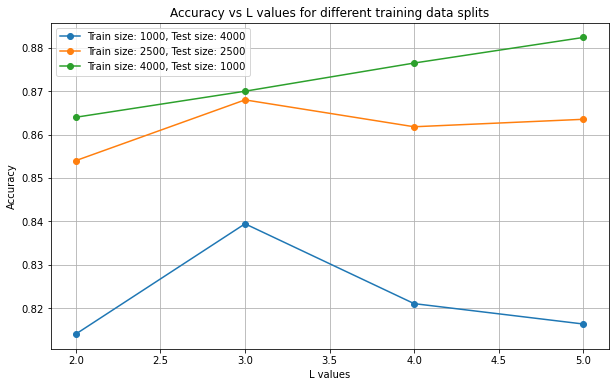

In [2]:
# Data
L_values = [2, 3, 4, 5]
splits = [(1000, 4000), (2500, 2500), (4000, 1000)]
accuracies = {
    (1000, 4000): [0.814, 0.8394166666666667, 0.821, 0.8163],
    (2500, 2500): [0.854, 0.868, 0.8618, 0.86352],
    (4000, 1000): [0.864, 0.87, 0.8765, 0.8824]
}

# Plotting
plt.figure(figsize=(10, 6))

for split in splits:
    plt.plot(L_values, accuracies[split], marker='o', label=f"Train size: {split[0]}, Test size: {split[1]}")

plt.xlabel('L values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs L values for different training data splits')
plt.legend()
plt.grid(True)
plt.show()
